In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
date_format = "%m/%d/%Y %H:%M:%S:%f"

**How does the raw dataset look like and what is the size of the raw file?**

In [51]:
df_raw = pd.read_excel('../datafiles/Insy6500_Project_Dataset_updated.xlsx')#raw data laoding
print(df_raw.head())
df_raw.info()

   Scan No.                timestamp  Resistor R1 40C  Resistor R1 60C  \
0         1  11/23/2024 00:15:48:669        104.40363        109.50066   
1         2  11/23/2024 01:15:48:653        104.37421        109.44822   
2         3  11/23/2024 02:15:48:653        104.37932        109.41880   
3         4  11/23/2024 03:15:48:653        104.38828        109.41880   
4         5  11/23/2024 04:15:48:653        104.39595        109.41752   

   Resistor R1 85C  Resistor R1 125C  Resistor R2 85C  Resistor R2 125C  \
0        108.38533         104.59037        11.680190         10.020005   
1        108.37254         104.51874        11.671119          9.469081   
2        108.40708         104.48421        11.666136          9.570143   
3        108.35463         104.49316        11.672141          9.740071   
4        108.38149         104.51618        11.675208          9.832318   

   Gain (Vout/Vin) 40C  Gain (Vout/Vin) 60C  Gain (Vout/Vin) 85C  \
0             1.645716             1

**Answer: The raw dataset has 12 columns with 5020 observation where the columns represent the component data and circuit data. There are two different resistors present and gain of the circuits at different temperatures where these circuits are aged to know the degradation behavior. The raw dataset consumes 470.8+ KB**

**What is the size of the dataset when the `timestamp` column is changed to datetime format?**

In [52]:
df = pd.read_excel(
    '../datafiles/Insy6500_Project_Dataset_updated.xlsx',
    parse_dates=["timestamp"],
    date_parser=lambda x: pd.to_datetime(x, format=date_format)
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Scan No.              5020 non-null   int64         
 1   timestamp             5020 non-null   datetime64[ns]
 2   Resistor R1 40C       5020 non-null   float64       
 3   Resistor R1 60C       5020 non-null   float64       
 4   Resistor R1 85C       5020 non-null   float64       
 5   Resistor R1 125C      5020 non-null   float64       
 6   Resistor R2 85C       5020 non-null   float64       
 7   Resistor R2 125C      5020 non-null   float64       
 8   Gain (Vout/Vin) 40C   5020 non-null   float64       
 9   Gain (Vout/Vin) 60C   5020 non-null   float64       
 10  Gain (Vout/Vin) 85C   5020 non-null   float64       
 11  Gain (Vout/Vin) 125C  5020 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 470.8 KB


C:\Users\HP\AppData\Local\Temp\ipykernel_8736\1397550598.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_excel(


**Answer: For the dataset, there is no categorical data, so only timestamp can be changed to datetime format. After changing, it consumes 470.8KB**

In [53]:
print(df.columns)
len(df.columns)


Index(['Scan No.', 'timestamp', 'Resistor R1 40C', 'Resistor R1 60C',
       'Resistor R1 85C', 'Resistor R1 125C', 'Resistor R2 85C',
       'Resistor R2 125C', 'Gain (Vout/Vin) 40C', 'Gain (Vout/Vin) 60C',
       'Gain (Vout/Vin) 85C', 'Gain (Vout/Vin) 125C'],
      dtype='object')


12

In [59]:
df.columns = [
    'Scan_no','timstamp','R1_40C','R1_60C','R1_85C','R1_125C',
    'R2_85C','R2_125C','Gain_40C','Gain_60C','Gain_85C','Gain_125C'
] #Changing column names for easier notation


**Why do we need data cleaning for this dataset?**

In [61]:
# Resistance columns
res_cols = ['R1_40C', 'R1_60C', 'R1_85C', 'R1_125C', 'R2_85C', 'R2_125C']

# Gain columns
gain_cols = ['Gain_40C', 'Gain_60C', 'Gain_85C', 'Gain_125C']

# 1. Remove negative values
df[res_cols] = df[res_cols].where(df[res_cols] >= 0, np.nan)
df[gain_cols] = df[gain_cols].where(df[gain_cols] >= 0, np.nan)

# 2. First interpolation
df[res_cols] = df[res_cols].interpolate(method='linear', limit_direction='both')
df[gain_cols] = df[gain_cols].interpolate(method='linear', limit_direction='both')

# 3. Remove outliers in resistance columns
for col in res_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    df[col] = df[col].where((df[col] >= lower) & (df[col] <= upper))

# 4. Remove outliers in gain columns
for col in gain_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    df[col] = df[col].where((df[col] >= lower) & (df[col] <= upper))

# 5. Interpolate again to fill NaNs created by outlier removal
df[res_cols] = df[res_cols].interpolate(method='linear', limit_direction='both')
df[gain_cols] = df[gain_cols].interpolate(method='linear', limit_direction='both')


**Answer: So for this dataset, the data has been acquired using data acquisition system, for the circuit I have used, the gain is always positive. However, specially for gain at 125C there is too many data with negative gain. Data acquisition system can also measure noise data or unwanted data. The negative gains are not sustained for long time. This is random. So this might impact the analysis. For this reason, the negative data has been replaced with `nan` values and then linear interpolation have been used to replace `nan` values with the average of prior and next data of the `nan` values. And also there can be outlier's which actually presents the data which are noises rather than actual data. So using IQR or interquartile range method this outliers can be removed.**

**What is the most repeated resistance values of R1 at each aging temperature?**

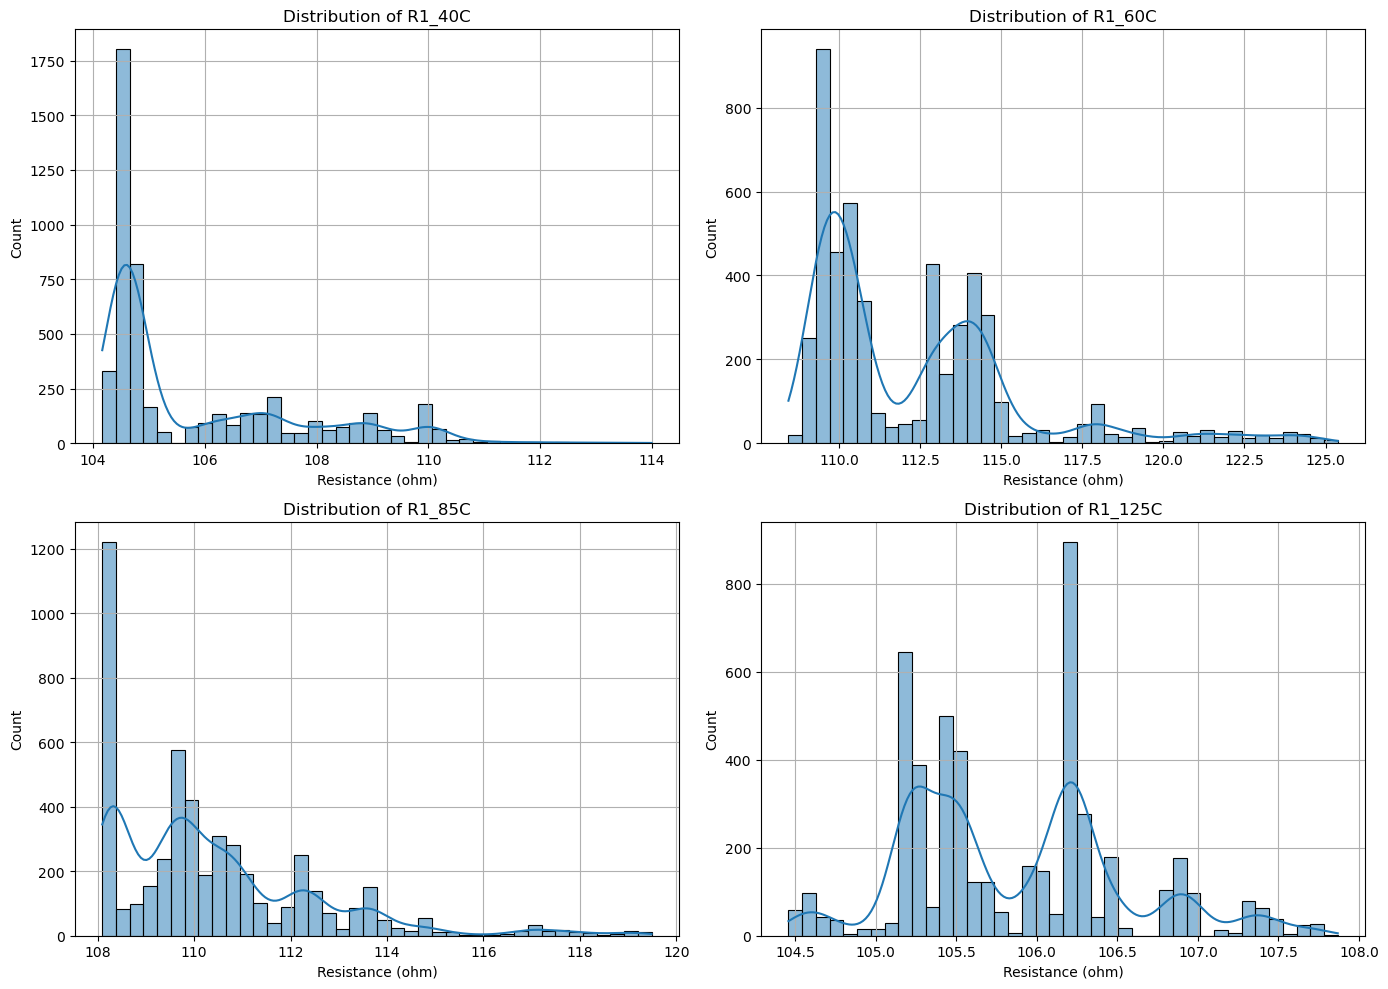

In [62]:
r1_cols = ['R1_40C', 'R1_60C', 'R1_85C', 'R1_125C']

plt.figure(figsize=(14,10))

for i, col in enumerate(r1_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Resistance (ohm)")
    plt.grid()

plt.tight_layout()
plt.show()


**Answer: To answer the question, histpot has been used. From the histplot, it can be seen that the values changed from 40C to 125C. Even, anamolies found at 60C. Since, R1 has a certain rated or manufactured value from the component manufacturer which is more likely little bit higher than 100 Ohm, it should be closely related to this value when put into circuit. It can change little bit because these components are assembled to additively manufactured circuits and these circuits has traces where we connect these resistors. And data acquisition system measures the trace resistance as well. However, it still should be close to 100 Ohm which is true for almost all the temperatures except at 60C. At 60C, some count also show resistance value at around 125 Ohm which is too higher than the rated resistance which is very errorneous result.**

**How does the standard deviation varies over time for the R1 resistor and different aging temperature?**

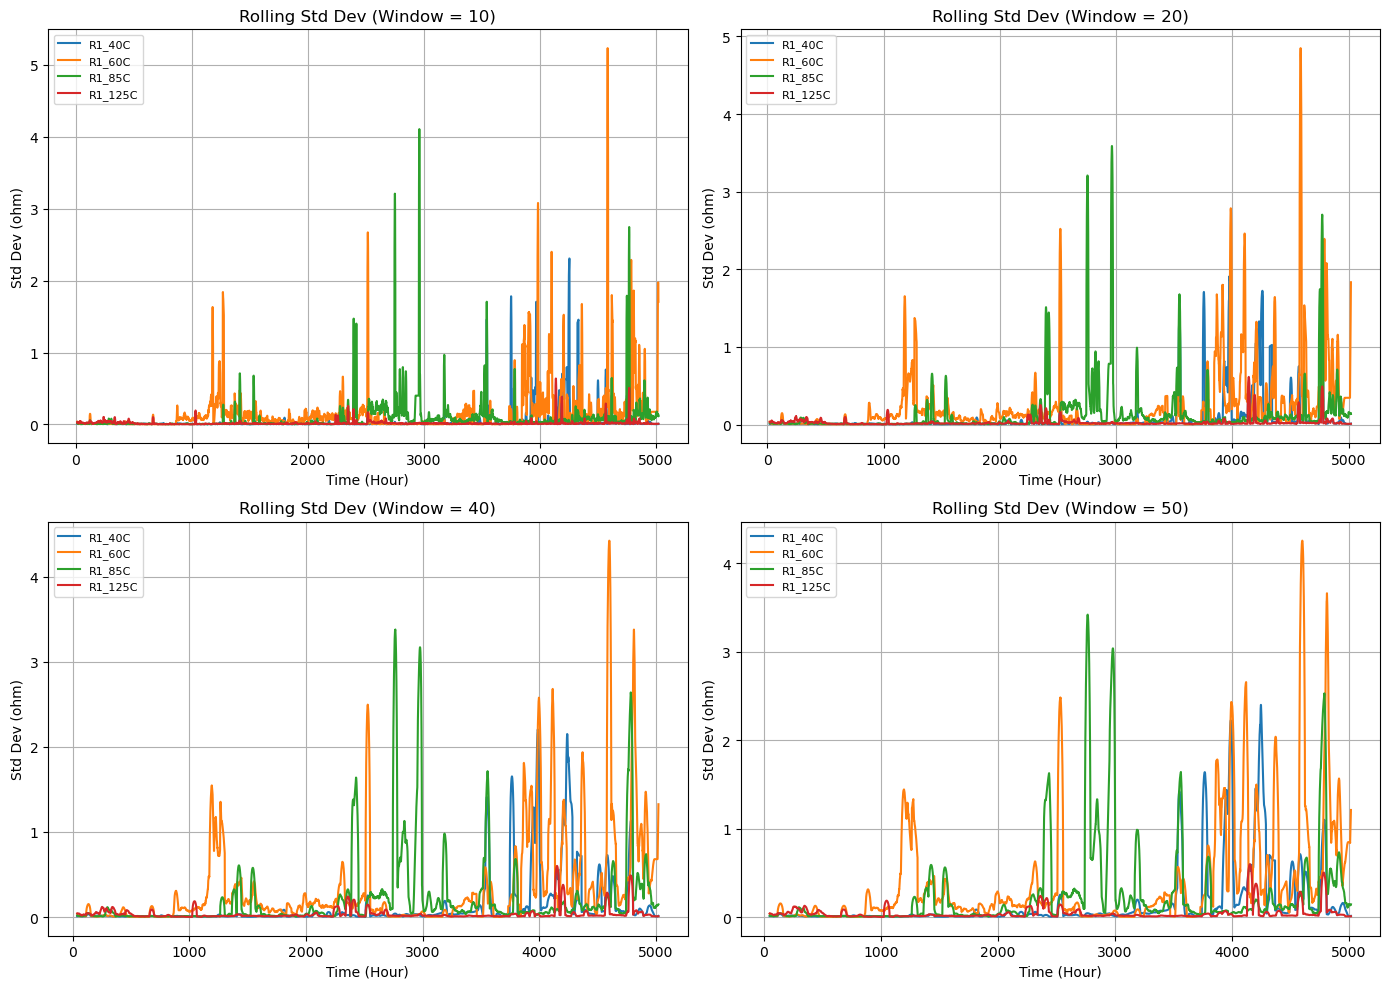

In [63]:
window_sizes = [10, 20, 40, 50]
cols = ['R1_40C','R1_60C','R1_85C','R1_125C']

plt.figure(figsize=(14,10))

for i, win in enumerate(window_sizes, 1):
    plt.subplot(2, 2, i)   # 2 rows, 2 columns, i-th plot
    
    for col in cols:
        plt.plot(df['Scan_no'], df[col].rolling(window=win).std(), label=col)

    plt.title(f"Rolling Std Dev (Window = {win})")
    plt.xlabel("Time (Hour)")
    plt.ylabel("Std Dev (ohm)")
    plt.grid()
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

**Answer: To answer this, different window size rolling standard deviation have been used. At low window for example window 10, it takes 10 consecutive points of the resistance vallues and tries to find standard deviation. Changing the window size help use to visualize the data in a broader way. At low window size, the spikes are instantaneous which indicates at which hour there is anamoly. With higher window size, this values gets smoothen out which ultimately hides the exact hour.**

**How does the gain vary and is there any relation between resistor R1 and gain?**

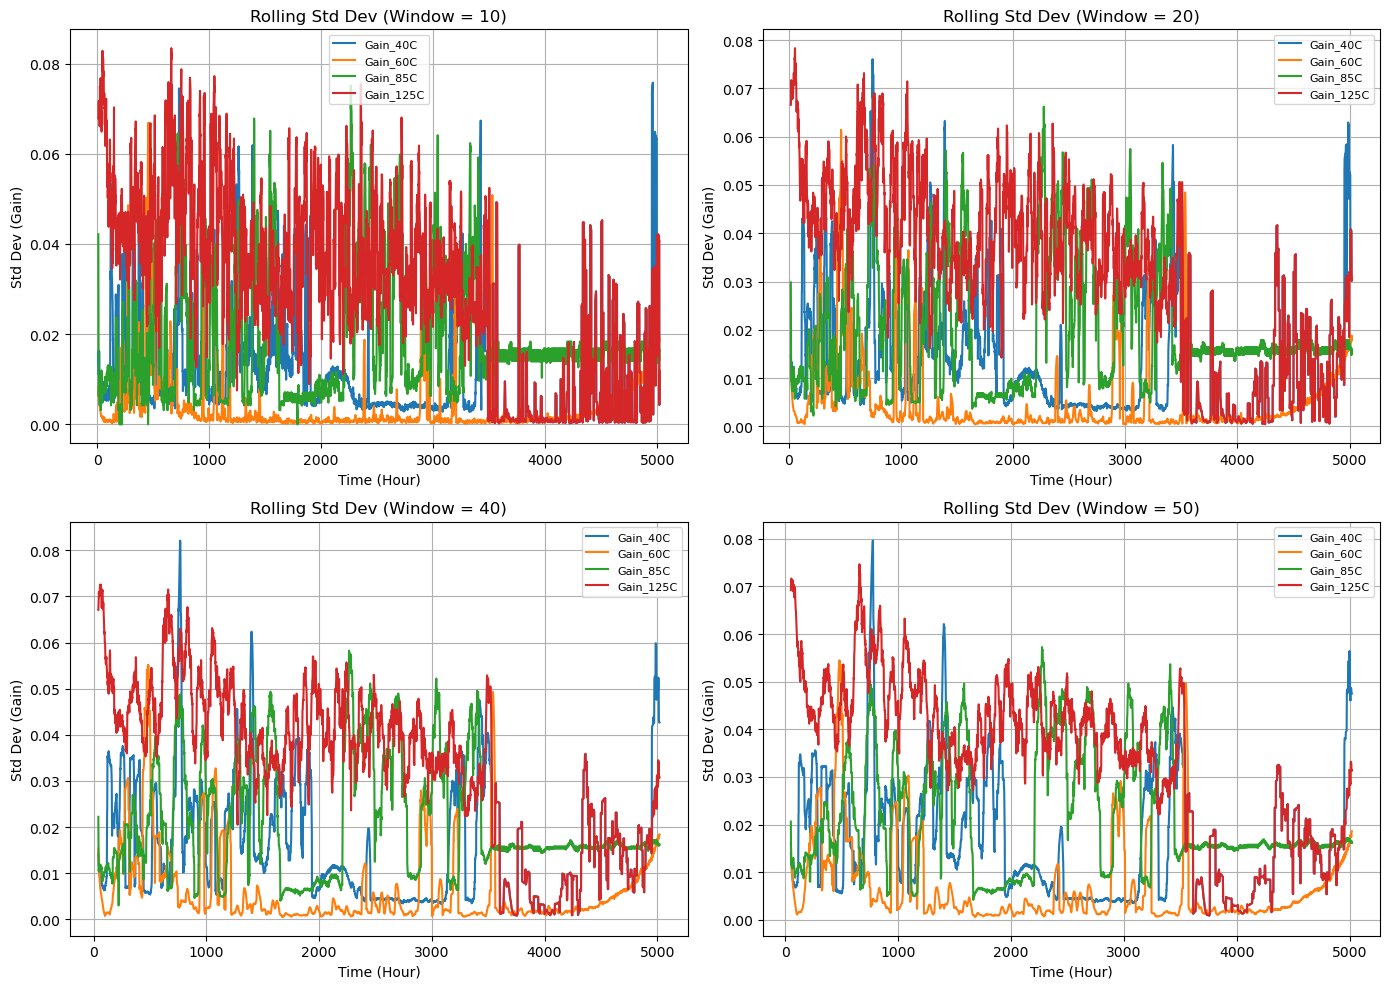

In [64]:
window_sizes = [10, 20, 40, 50]
cols = ['Gain_40C','Gain_60C','Gain_85C','Gain_125C']

plt.figure(figsize=(14,10))

for i, win in enumerate(window_sizes, 1):
    plt.subplot(2, 2, i)   # 2 rows, 2 columns, i-th plot
    
    for col in cols:
        plt.plot(df['Scan_no'], df[col].rolling(window=win).std(), label=col)

    plt.title(f"Rolling Std Dev (Window = {win})")
    plt.xlabel("Time (Hour)")
    plt.ylabel("Std Dev (Gain)")
    plt.grid()
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

**Answer: To answer this, similar rolling standard deviation have been plotted for gain. It can be seen that the most errorneous result are present in `Gain_125C`. This is little bit off the analysis because at 125C R1 behaved pretty well. However, gain is circuit performance rather than component performance. A circuit does not depend only on a specific component. It is possible that though R1 is stable enough, other components of the circuit might have failed which caused the whole circuit to perform bad.**

**Every circuit has a theoretical gain. Calculate the theoretical gain over time.**

In [65]:
df['Theoretical_Gain_85C'] = df['R1_85C']/(5*df['R2_85C'])#for a circuit one can measure the theoretical gain. Vout/Vin this is basically experimental gain. And for this particular circuit theoretical gain is (R1/5R2).
df['Theoretical_Gain_125C'] = df['R1_125C']/(5*df['R2_125C'])
df.head()

,Scan_no,timstamp,R1_40C,R1_60C,R1_85C,R1_125C,R2_85C,R2_125C,Gain_40C,Gain_60C,Gain_85C,Gain_125C,Theoretical_Gain_85C,Theoretical_Gain_125C
0,1,11/23/2024 00:15:48:669,104.40363,109.50066,108.38533,104.59037,11.680190,10.020005,1.645716,1.748604,1.76,1.754837,1.855883,2.087631
1,2,11/23/2024 01:15:48:653,104.37421,109.44822,108.37254,104.51874,11.671119,9.469081,1.646289,1.742302,1.70,1.764511,1.857106,2.207579
2,3,11/23/2024 02:15:48:653,104.37932,109.41880,108.40708,104.48421,11.666136,9.570143,1.647146,1.738339,1.75,1.749867,1.858492,2.183545
3,4,11/23/2024 03:15:48:653,104.38828,109.41880,108.35463,104.49316,11.672141,9.740071,1.650871,1.735000,1.66,1.709196,1.856637,2.145634
4,5,11/23/2024 04:15:48:653,104.39595,109.41752,108.38149,104.51618,11.675208,9.832318,1.678576,1.732703,1.66,1.642838,1.856609,2.125972


**For this particular circuit, the theoretical gain is (R1/5R2) which has been calculated for 85C and 125C since this dataset provides data for R2 at 85C and 125C only.**

**How does the error changes over time? This error is basically the error between theoretical and experimental gain. Show visualisation of the error.**

In [66]:
# % Error in experimental gain with respect to theoretical gain
df['Error_85C'] = abs((df['Gain_85C']-df['Theoretical_Gain_85C'])*100/df['Theoretical_Gain_85C'])
df['Error_125C'] = abs((df['Gain_125C']-df['Theoretical_Gain_125C'])*100/df['Theoretical_Gain_125C'])
df.head()

,Scan_no,timstamp,R1_40C,R1_60C,R1_85C,R1_125C,R2_85C,R2_125C,Gain_40C,Gain_60C,Gain_85C,Gain_125C,Theoretical_Gain_85C,Theoretical_Gain_125C,Error_85C,Error_125C
0,1,11/23/2024 00:15:48:669,104.40363,109.50066,108.38533,104.59037,11.680190,10.020005,1.645716,1.748604,1.76,1.754837,1.855883,2.087631,5.166435,15.941234
1,2,11/23/2024 01:15:48:653,104.37421,109.44822,108.37254,104.51874,11.671119,9.469081,1.646289,1.742302,1.70,1.764511,1.857106,2.207579,8.459734,20.070322
2,3,11/23/2024 02:15:48:653,104.37932,109.41880,108.40708,104.48421,11.666136,9.570143,1.647146,1.738339,1.75,1.749867,1.858492,2.183545,5.837617,19.861182
3,4,11/23/2024 03:15:48:653,104.38828,109.41880,108.35463,104.49316,11.672141,9.740071,1.650871,1.735000,1.66,1.709196,1.856637,2.145634,10.591019,20.340759
4,5,11/23/2024 04:15:48:653,104.39595,109.41752,108.38149,104.51618,11.675208,9.832318,1.678576,1.732703,1.66,1.642838,1.856609,2.125972,10.589690,22.725352


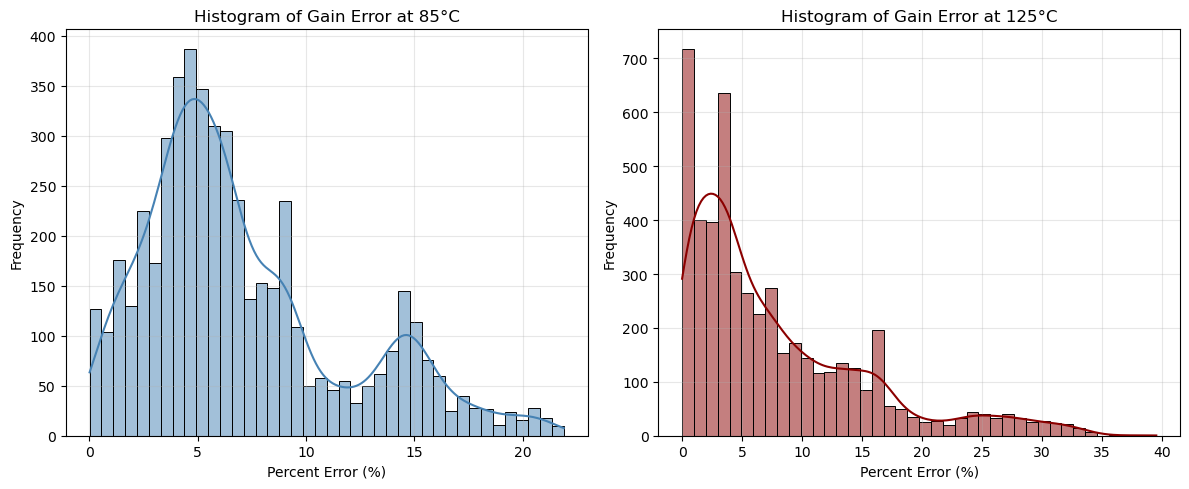

In [67]:
plt.figure(figsize=(12,5))

# 85°C Error Histogram
plt.subplot(1,2,1)
sns.histplot(df['Error_85C'], bins=40, kde=True, color='steelblue')
plt.title("Histogram of Gain Error at 85°C")
plt.xlabel("Percent Error (%)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

# 125°C Error Histogram
plt.subplot(1,2,2)
sns.histplot(df['Error_125C'], bins=40, kde=True, color='darkred')
plt.title("Histogram of Gain Error at 125°C")
plt.xlabel("Percent Error (%)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**Answer: To answer the question, the error has been calculated and histplot has been developed. At 85C the error percentage is lower in comparison to the error percantage at 125C which is reasonable because at 125C the circuit performance degraded rapidly.**

**Show experimental vs theoretical gain deviation over time.**

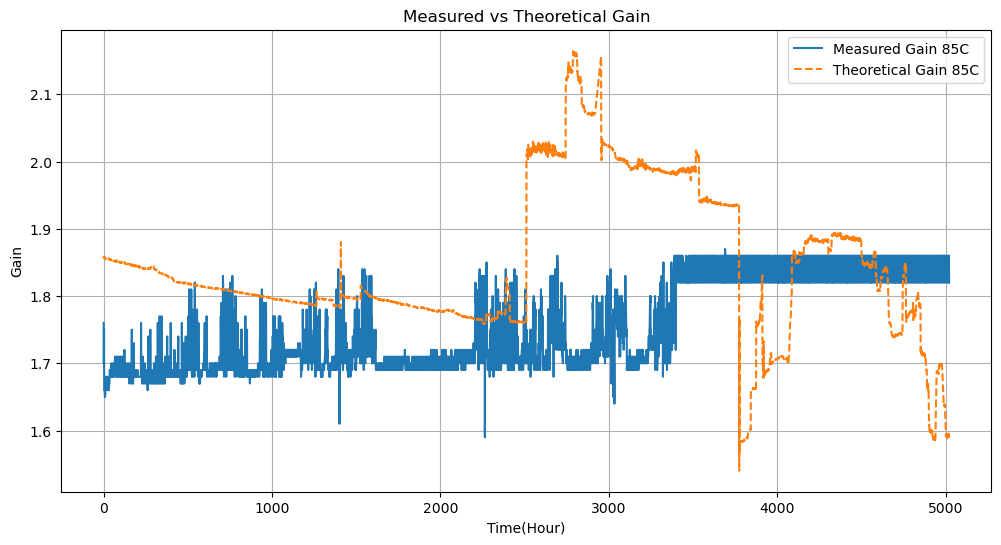

In [68]:
plt.figure(figsize=(12,6))
plt.plot(df['Scan_no'], df['Gain_85C'], label="Measured Gain 85C")
plt.plot(df['Scan_no'], df['Theoretical_Gain_85C'], label="Theoretical Gain 85C", linestyle='--')



plt.title("Measured vs Theoretical Gain")
plt.xlabel("Time(Hour)")
plt.ylabel("Gain")
plt.legend()
plt.grid()
plt.show()

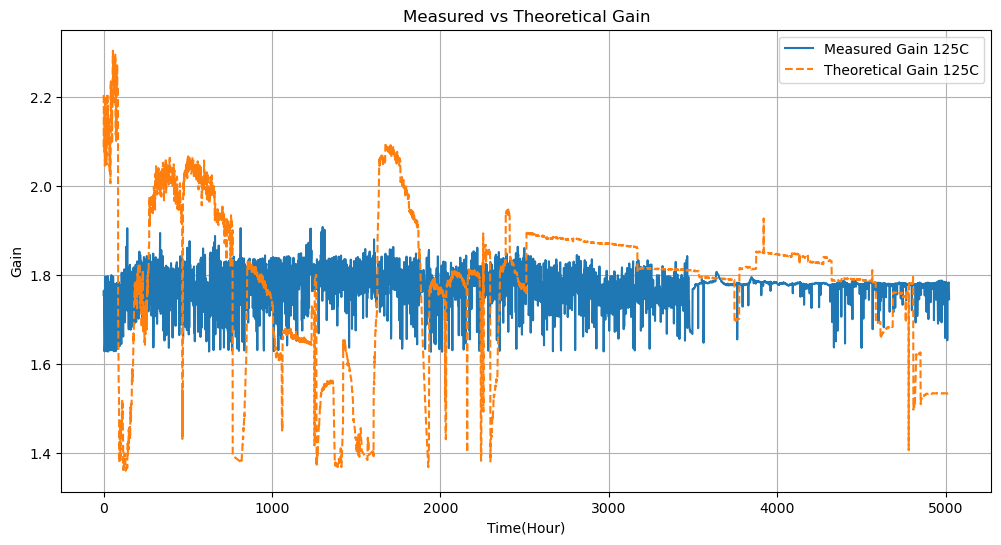

In [69]:
plt.figure(figsize=(12,6))
plt.plot(df['Scan_no'], df['Gain_125C'], label="Measured Gain 125C")
plt.plot(df['Scan_no'], df['Theoretical_Gain_125C'], label="Theoretical Gain 125C", linestyle='--')



plt.title("Measured vs Theoretical Gain")
plt.xlabel("Time(Hour)")
plt.ylabel("Gain")
plt.legend()
plt.grid()
plt.show()

**Show the pass fail criteria and how long R1, R2 and circuit i.e. the Gain survives.**

In [70]:
#Pass fail criteria for resistances
#The pass fail criteria comes from daisy chain criterion which says any component is failed if it changes its value by +-20% from the initial value.
r1_40c= df.loc[0,'R1_40C']
r1_60c = df.loc[0, 'R1_60C']
r1_85c = df.loc[0, 'R1_85C']
r1_125c = df.loc[0, 'R1_125C']
r2_85c = df.loc[0, 'R2_85C']
r2_125c = df.loc[0, 'R2_125C']
lower_r1_40c = 0.8*r1_40c
lower_r1_60c = 0.8*r1_60c
lower_r1_85c = 0.8*r1_85c
lower_r1_125c = 0.8*r1_125c
lower_r2_85c = 0.8*r2_85c
lower_r2_125c = 0.8*r2_125c
upper_r1_40c = 1.2*r1_40c
upper_r1_60c = 1.2*r1_60c
upper_r1_85c = 1.2*r1_85c
upper_r1_125c = 1.2*r1_125c
upper_r2_85c = 1.2*r2_85c
upper_r2_125c = 1.2*r2_125c
df['Passed_R1_40C'] = (df['R1_40C'] >= lower_r1_40c) & (df['R1_40C'] <= upper_r1_40c)
df['Passed_R1_60C'] = (df['R1_60C'] >= lower_r1_60c) & (df['R1_60C'] <= upper_r1_60c)
df['Passed_R1_85C'] = (df['R1_85C'] >= lower_r1_85c) & (df['R1_85C'] <= upper_r1_85c)
df['Passed_R1_125C'] = (df['R1_125C'] >= lower_r1_125c) & (df['R1_125C'] <= upper_r1_125c)
df['Passed_R2_85C'] = (df['R2_85C'] >= lower_r2_85c) & (df['R2_85C'] <= upper_r2_85c)
df['Passed_R2_125C'] = (df['R2_125C'] >= lower_r2_125c) & (df['R2_125C'] <= upper_r2_125c)
df.head()

,Scan_no,timstamp,R1_40C,R1_60C,R1_85C,R1_125C,R2_85C,R2_125C,Gain_40C,Gain_60C,...,Theoretical_Gain_85C,Theoretical_Gain_125C,Error_85C,Error_125C,Passed_R1_40C,Passed_R1_60C,Passed_R1_85C,Passed_R1_125C,Passed_R2_85C,Passed_R2_125C
0,1,11/23/2024 00:15:48:669,104.40363,109.50066,108.38533,104.59037,11.680190,10.020005,1.645716,1.748604,...,1.855883,2.087631,5.166435,15.941234,True,True,True,True,True,True
1,2,11/23/2024 01:15:48:653,104.37421,109.44822,108.37254,104.51874,11.671119,9.469081,1.646289,1.742302,...,1.857106,2.207579,8.459734,20.070322,True,True,True,True,True,True
2,3,11/23/2024 02:15:48:653,104.37932,109.41880,108.40708,104.48421,11.666136,9.570143,1.647146,1.738339,...,1.858492,2.183545,5.837617,19.861182,True,True,True,True,True,True
3,4,11/23/2024 03:15:48:653,104.38828,109.41880,108.35463,104.49316,11.672141,9.740071,1.650871,1.735000,...,1.856637,2.145634,10.591019,20.340759,True,True,True,True,True,True
4,5,11/23/2024 04:15:48:653,104.39595,109.41752,108.38149,104.51618,11.675208,9.832318,1.678576,1.732703,...,1.856609,2.125972,10.589690,22.725352,True,True,True,True,True,True


In [71]:
#Pass fail criteria for Gain using the same daisy chain criterion
#Gain is more like circuit level property i.e. if gain is on the failed region, circuit is failed and resistance is component level property. So even if a component fails, circuit may still be functional becuase it depends on many more components.
gain_40c= df.loc[0,'Gain_40C']
gain_60c = df.loc[0, 'Gain_60C']
gain_85c = df.loc[0, 'Gain_85C']
gain_125c = df.loc[0, 'Gain_125C']
lower_gain_40c = 0.8*gain_40c
lower_gain_60c = 0.8*gain_60c
lower_gain_85c = 0.8*gain_85c
lower_gain_125c = 0.8*gain_125c
upper_gain_40c = 1.2*gain_40c
upper_gain_60c = 1.2*gain_60c
upper_gain_85c = 1.2*gain_85c
upper_gain_125c = 1.2*gain_125c
df['Passed_Gain_40C'] = (df['Gain_40C'] >= lower_gain_40c) & (df['Gain_40C'] <= upper_gain_40c)
df['Passed_Gain_60C'] = (df['Gain_60C'] >= lower_gain_60c) & (df['Gain_60C'] <= upper_gain_60c)
df['Passed_Gain_85C'] = (df['Gain_85C'] >= lower_gain_85c) & (df['Gain_85C'] <= upper_gain_85c)
df['Passed_Gain_125C'] = (df['Gain_125C'] >= lower_gain_125c) & (df['Gain_125C'] <= upper_gain_125c)
df.head()

,Scan_no,timstamp,R1_40C,R1_60C,R1_85C,R1_125C,R2_85C,R2_125C,Gain_40C,Gain_60C,...,Passed_R1_40C,Passed_R1_60C,Passed_R1_85C,Passed_R1_125C,Passed_R2_85C,Passed_R2_125C,Passed_Gain_40C,Passed_Gain_60C,Passed_Gain_85C,Passed_Gain_125C
0,1,11/23/2024 00:15:48:669,104.40363,109.50066,108.38533,104.59037,11.680190,10.020005,1.645716,1.748604,...,True,True,True,True,True,True,True,True,True,True
1,2,11/23/2024 01:15:48:653,104.37421,109.44822,108.37254,104.51874,11.671119,9.469081,1.646289,1.742302,...,True,True,True,True,True,True,True,True,True,True
2,3,11/23/2024 02:15:48:653,104.37932,109.41880,108.40708,104.48421,11.666136,9.570143,1.647146,1.738339,...,True,True,True,True,True,True,True,True,True,True
3,4,11/23/2024 03:15:48:653,104.38828,109.41880,108.35463,104.49316,11.672141,9.740071,1.650871,1.735000,...,True,True,True,True,True,True,True,True,True,True
4,5,11/23/2024 04:15:48:653,104.39595,109.41752,108.38149,104.51618,11.675208,9.832318,1.678576,1.732703,...,True,True,True,True,True,True,True,True,True,True


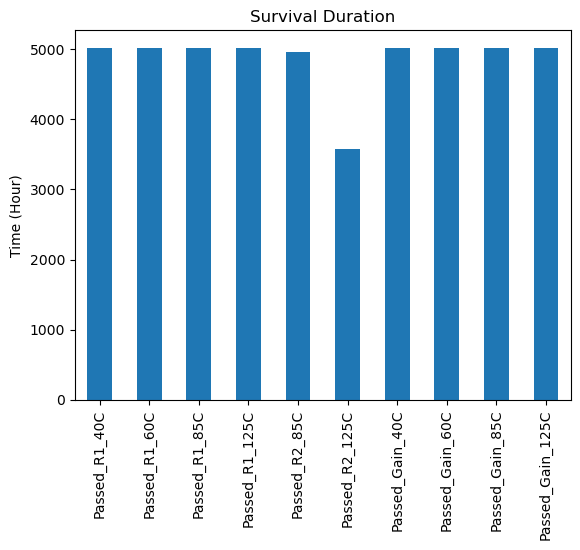

In [72]:
bool_cols = ['Passed_R1_40C', 'Passed_R1_60C', 'Passed_R1_85C', 'Passed_R1_125C','Passed_R2_85C','Passed_R2_125C','Passed_Gain_40C','Passed_Gain_60C','Passed_Gain_85C','Passed_Gain_125C']

df[bool_cols].sum().plot(kind='bar')
plt.ylabel("Time (Hour)")
plt.title("Survival Duration")
plt.show()

**Answer: The bar plot shows the circuit survival duration. Overall at all temperatures, everything survived for almost similar duration. However, at 125C R2 fails significantly faster.**

**Calculate the degradation rate for R1,R2 and gain over time.**

In [73]:
#degradation rate for every hour. This code basically shows the every hour resistance and gain degradation.
df['DegradationRate_R1_40C']= abs(df['R1_40C'].diff())
df['DegradationRate_R1_60C']= abs(df['R1_60C'].diff())
df['DegradationRate_R1_85C']= abs(df['R1_85C'].diff())
df['DegradationRate_R1_125C']= abs(df['R1_125C'].diff())
df['DegradationRate_R2_85C']= abs(df['R2_85C'].diff())
df['DegradationRate_R2_125C']= abs(df['R2_125C'].diff())
df['DegradationRate_Gain_40C']= abs(df['Gain_40C'].diff())
df['DegradationRate_Gain_60C']= abs(df['Gain_60C'].diff())
df['DegradationRate_Gain_85C']= abs(df['Gain_85C'].diff())
df['DegradationRate_Gain_125C']= abs(df['Gain_125C'].diff())
df.head()

,Scan_no,timstamp,R1_40C,R1_60C,R1_85C,R1_125C,R2_85C,R2_125C,Gain_40C,Gain_60C,...,DegradationRate_R1_40C,DegradationRate_R1_60C,DegradationRate_R1_85C,DegradationRate_R1_125C,DegradationRate_R2_85C,DegradationRate_R2_125C,DegradationRate_Gain_40C,DegradationRate_Gain_60C,DegradationRate_Gain_85C,DegradationRate_Gain_125C
0,1,11/23/2024 00:15:48:669,104.40363,109.50066,108.38533,104.59037,11.680190,10.020005,1.645716,1.748604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11/23/2024 01:15:48:653,104.37421,109.44822,108.37254,104.51874,11.671119,9.469081,1.646289,1.742302,...,0.02942,0.05244,0.01279,0.07163,0.009071,0.550924,0.000573,0.006302,0.06,0.009674
2,3,11/23/2024 02:15:48:653,104.37932,109.41880,108.40708,104.48421,11.666136,9.570143,1.647146,1.738339,...,0.00511,0.02942,0.03454,0.03453,0.004983,0.101062,0.000857,0.003962,0.05,0.014644
3,4,11/23/2024 03:15:48:653,104.38828,109.41880,108.35463,104.49316,11.672141,9.740071,1.650871,1.735000,...,0.00896,0.00000,0.05245,0.00895,0.006005,0.169928,0.003725,0.003340,0.09,0.040671
4,5,11/23/2024 04:15:48:653,104.39595,109.41752,108.38149,104.51618,11.675208,9.832318,1.678576,1.732703,...,0.00767,0.00128,0.02686,0.02302,0.003067,0.092247,0.027706,0.002296,0.00,0.066358


**Calculate the activation energy and acceleration factor model for R1 and Gain.**

In [74]:
#Activation energy calculation for resistance R1
#Using activation energy we can develop acceleration factor model which will eventually give an estimation for failure analysis.
#For this dataset, it is for sustained high temperature analysis which means circuit performance has been monitored at certain temperature for longer period of time.
#The acceleration factor model for this is ln(Xt/X0) = nlnt -Ea/K(1/T1-1/T2) where Xt is the circuit parameter values at different aging times, X0 is the hour 0 value, t is the aging time, n is time constant, Ea is activation energy, K is boltzman constant, T is aging temperature.
#Acceleration Factor model, AF = t^n.e-Ea/k(1/T1-1/T2)
#First calculation of n
df['ln(R1/R0)_40C'] = np.log(df['R1_40C']/r1_40c)
df['ln(R1/R0)_60C'] = np.log(df['R1_60C']/r1_60c)
df['ln(R1/R0)_85C'] = np.log(df['R1_85C']/r1_85c)
df['ln(R1/R0)_125C'] = np.log(df['R1_125C']/r1_125c)
df['Combined_ln(R1/R0)'] =df[['ln(R1/R0)_40C','ln(R1/R0)_60C','ln(R1/R0)_85C','ln(R1/R0)_125C']].mean(axis=1)
n, intercept = np.polyfit((df['Scan_no']-1), df['Combined_ln(R1/R0)'], 1)#here scan_no can be considered as hour and scan 1 is basically hour 0 and time constant 'n' should be same for all the temperatures based on the model
print(f"The time constant for R1 resistance is {n}\n")
#Activation energy calculation. This can be done at different time interval. I will do it for the first 1000 hour interval. For  that we need kelvin temperature. Temprature varied from 40C to 125C.
T1=40+273
T2=60+273
T3=85+273
T4=125+273
x=[1/T1,1/T2,1/T3,1/T4]
y=[(df.loc[1000,'ln(R1/R0)_40C']),(df.loc[1000,'ln(R1/R0)_60C']),(df.loc[1000,'ln(R1/R0)_85C']),(df.loc[1000,'ln(R1/R0)_125C'])]
slope, _ = np.polyfit(x,y,1)
k= 8.617333262e-5 #Boltzman constant in eV
Ea = -slope*k #activation energy
print(f"Activation energy for the R1 resistor is {Ea} eV")
from IPython.display import display, Math
print("So the acceleration factor model for R1 resistor is")
display(Math(rf'AF = t^{{{n}}} \cdot e^{{-{Ea}/k \cdot (1/T_1 - 1/T_2)}}'))

The time constant for R1 resistance is 8.075430679738701e-06

Activation energy for the R1 resistor is 0.0006371197523059912 eV
So the acceleration factor model for R1 resistor is


<IPython.core.display.Math object>

In [75]:
#Activation energy calculation for Gain
#Using activation energy we can develop acceleration factor model which will eventually give an estimation for failure analysis.
#For this dataset, it is for sustained high temperature analysis which means circuit performance has been monitored at certain temperature for longer period of time.
#The acceleration factor model for this is ln(Xt/X0) = nlnt -Ea/K(1/T1-1/T2) where Xt is the circuit parameter values at different aging times, X0 is the hour 0 value, t is the aging time, n is time constant, Ea is activation energy, K is boltzman constant, T is aging temperature.
#Acceleration Factor model, AF = t^n.e-Ea/k(1/T1-1/T2)
#First calculation of n
df['ln(Gain/Gain0)_40C'] = np.log(df['Gain_40C']/gain_40c)
df['ln(Gain/Gain0)_60C'] = np.log(df['Gain_60C']/gain_60c)
df['ln(Gain/Gain0)_85C'] = np.log(df['Gain_85C']/gain_85c)
df['ln(Gain/Gain0)_125C'] = np.log(df['Gain_125C']/gain_125c)
df['Combined_ln(Gain/Gain0)'] =df[['ln(Gain/Gain0)_40C','ln(Gain/Gain0)_60C','ln(Gain/Gain0)_85C','ln(Gain/Gain0)_125C']].mean(axis=1)
n1, intercept1 = np.polyfit((df['Scan_no']-1), df['Combined_ln(Gain/Gain0)'], 1)#here scan_no can be considered as hour and scan 1 is basically hour 0 and time constant 'n' should be same for all the temperatures based on the model
print(f"The time constant for Gain is {n1}\n")
#Activation energy calculation. This can be done at different time interval. I will do it for every 1000 hour interval. For  that we need kelvin temperature. Temprature varied from 40C to 125C.
T1=40+273
T2=60+273
T3=85+273
T4=125+273
x1=[1/T1,1/T2,1/T3,1/T4]
y1=[(df.loc[1000,'ln(Gain/Gain0)_40C']),(df.loc[1000,'ln(Gain/Gain0)_60C']),(df.loc[1000,'ln(Gain/Gain0)_85C']),(df.loc[1000,'ln(Gain/Gain0)_125C'])]
slope1, _ = np.polyfit(x1,y1,1)
k= 8.617333262e-5 #Boltzman constant in eV
Ea1 = -slope1*k #activation energy
print(f"Activation energy for the Gain is {Ea1} eV")
from IPython.display import display, Math
print("So the acceleration factor model for Gain is")
display(Math(rf'AF = t^{{{n1}}} \cdot e^{{-{Ea1}/k \cdot (1/T_1 - 1/T_2)}}'))


The time constant for Gain is 3.996587763702662e-06

Activation energy for the Gain is -0.0062289838460598684 eV
So the acceleration factor model for Gain is


<IPython.core.display.Math object>

**Show the fit for time constant calculation for R1 and Gain. Is there any reason to get different activation energy and acceleration factor model?**

In [76]:
df[['ln(R1/R0)_40C','ln(R1/R0)_60C','ln(R1/R0)_85C','ln(R1/R0)_125C','Combined_ln(R1/R0)']].head()


,ln(R1/R0)_40C,ln(R1/R0)_60C,ln(R1/R0)_85C,ln(R1/R0)_125C,Combined_ln(R1/R0)
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.000282,-0.000479,-0.000118,-0.000685,-0.000391
2,-0.000233,-0.000748,0.000201,-0.001016,-0.000449
3,-0.000147,-0.000748,-0.000283,-0.000930,-0.000527
4,-0.000074,-0.000760,-0.000035,-0.000710,-0.000395


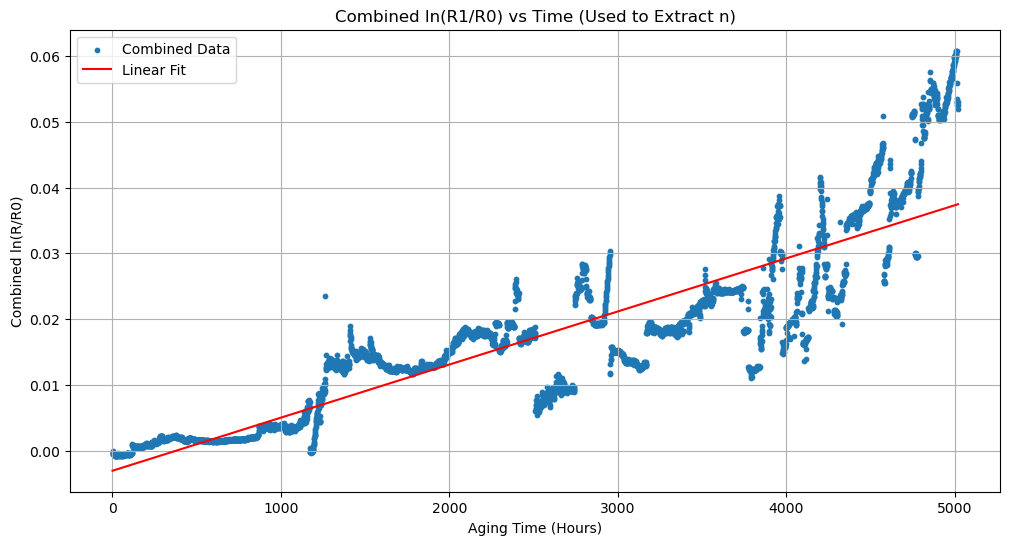

In [77]:
plt.figure(figsize=(12,6))

plt.scatter(df['Scan_no'], df['Combined_ln(R1/R0)'], s=10, label="Combined Data")
plt.plot(df['Scan_no'], n*df['Scan_no'] + intercept, color='red', label="Linear Fit")

plt.title("Combined ln(R1/R0) vs Time (Used to Extract n)")
plt.xlabel("Aging Time (Hours)")
plt.ylabel("Combined ln(R/R0)")
plt.legend()
plt.grid()
plt.show()

In [78]:
df[['ln(Gain/Gain0)_40C','ln(Gain/Gain0)_60C','ln(Gain/Gain0)_85C','ln(Gain/Gain0)_125C','Combined_ln(Gain/Gain0)']].head()


,ln(Gain/Gain0)_40C,ln(Gain/Gain0)_60C,ln(Gain/Gain0)_85C,ln(Gain/Gain0)_125C,Combined_ln(Gain/Gain0)
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000348,-0.003611,-0.034686,0.005498,-0.008113
2,0.000869,-0.005887,-0.005698,-0.002836,-0.003388
3,0.003128,-0.007811,-0.058496,-0.026353,-0.022383
4,0.019771,-0.009135,-0.058496,-0.065951,-0.028453


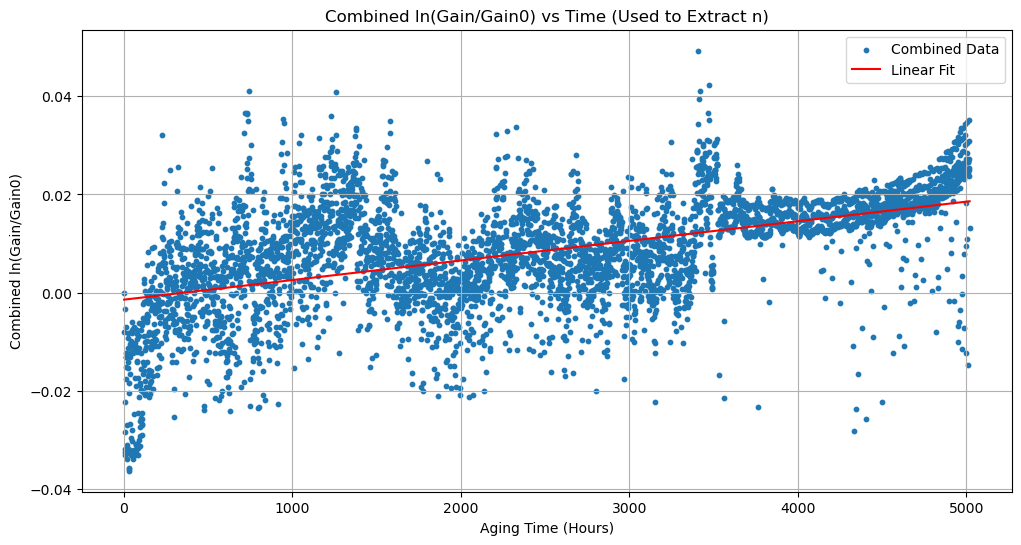

In [79]:
plt.figure(figsize=(12,6))

plt.scatter(df['Scan_no'], df['Combined_ln(Gain/Gain0)'], s=10, label="Combined Data")
plt.plot(df['Scan_no'], n1*df['Scan_no'] + intercept1, color='red', label="Linear Fit")

plt.title("Combined ln(Gain/Gain0) vs Time (Used to Extract n)")
plt.xlabel("Aging Time (Hours)")
plt.ylabel("Combined ln(Gain/Gain0)")
plt.legend()
plt.grid()
plt.show()


**Answer: There are different acceleration factor models and activation energies found. One of the reason could be the outlier present in resistance data which is most probably possible because of the data found in Gain. Because gain depends more likely on everything in the circuit which is why gain deviation is different than the component deviation.**

**Show the resistance deviation of R1 for all the temperatures for the aging duration.**

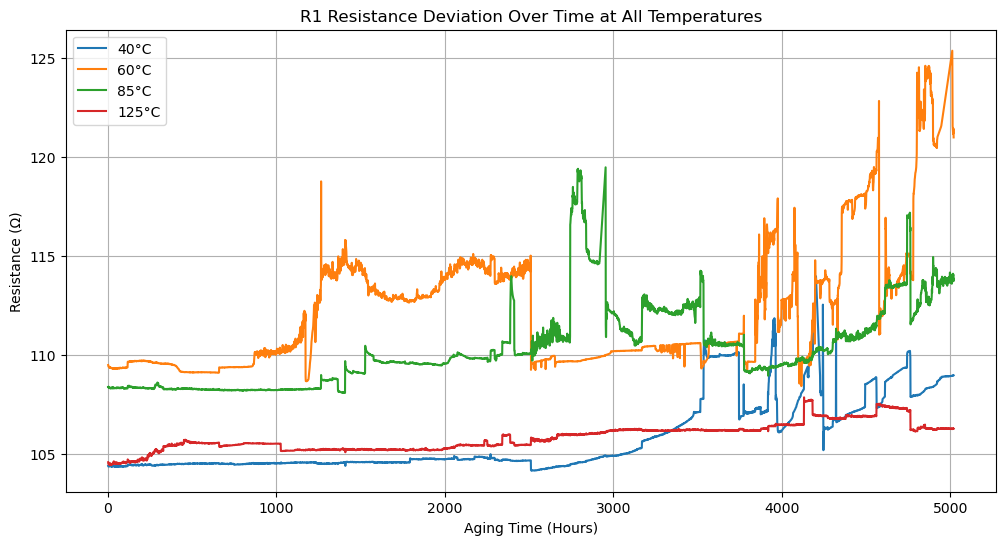

In [80]:
plt.figure(figsize=(12,6))

plt.plot(df['Scan_no'], df['R1_40C'], label="40°C")
plt.plot(df['Scan_no'], df['R1_60C'], label="60°C")
plt.plot(df['Scan_no'], df['R1_85C'], label="85°C")
plt.plot(df['Scan_no'], df['R1_125C'], label="125°C")

plt.title("R1 Resistance Deviation Over Time at All Temperatures")
plt.xlabel("Aging Time (Hours)")
plt.ylabel("Resistance (Ω)")
plt.legend()
plt.grid()
plt.show()


**Show the degradation rate deviation for R1 for all the temperatures.**

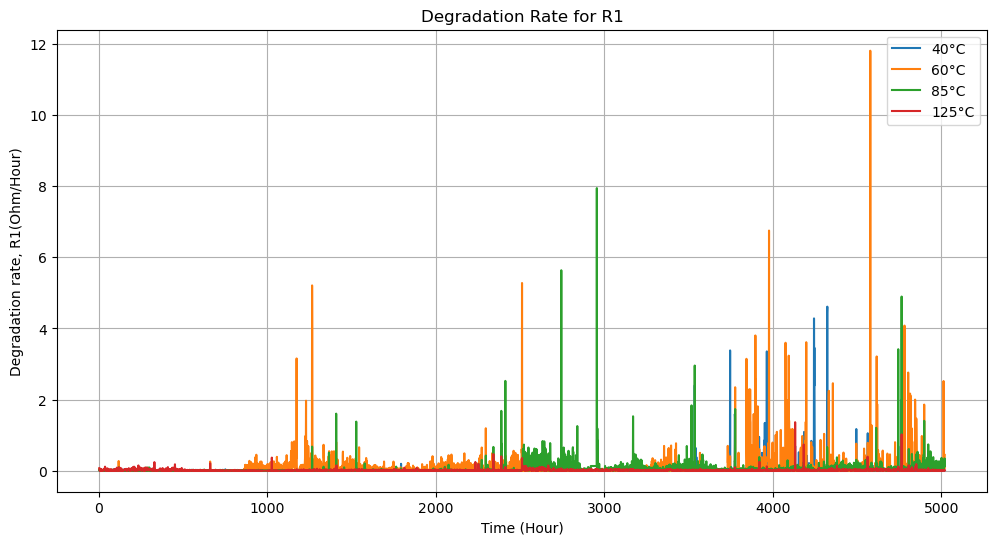

In [81]:
plt.figure(figsize=(12,6))

plt.plot(df['Scan_no'], df['DegradationRate_R1_40C'], label="40°C")
plt.plot(df['Scan_no'], df['DegradationRate_R1_60C'], label="60°C")
plt.plot(df['Scan_no'], df['DegradationRate_R1_85C'], label="85°C")
plt.plot(df['Scan_no'], df['DegradationRate_R1_125C'], label="125°C")
plt.title("Degradation Rate for R1")
plt.xlabel("Time (Hour)")
plt.ylabel("Degradation rate, R1(Ohm/Hour)")
plt.legend()
plt.grid()
plt.show()


**Show the degradation rate deviation for R2 for all the temperatures.**

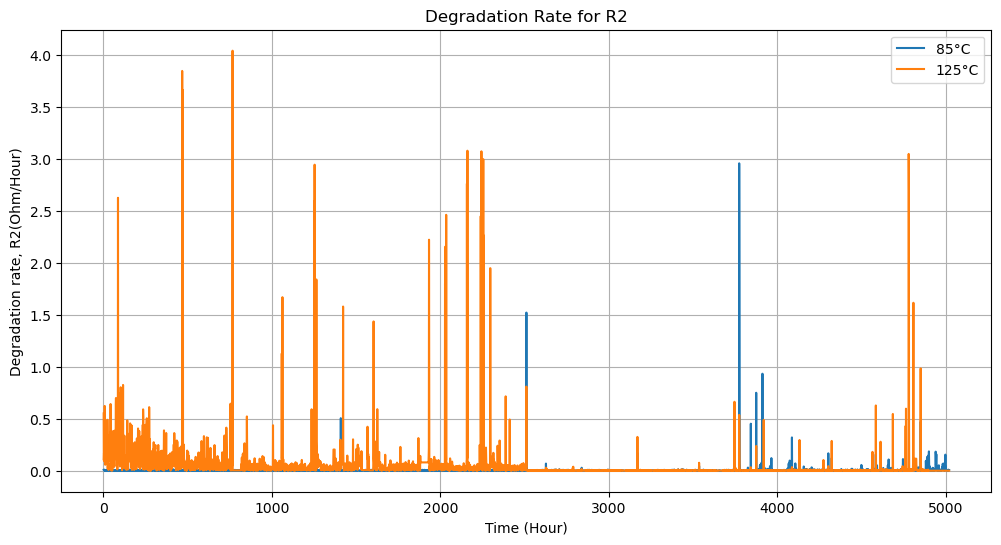

In [82]:
plt.figure(figsize=(12,6))
plt.plot(df['Scan_no'], df['DegradationRate_R2_85C'], label="85°C")
plt.plot(df['Scan_no'], df['DegradationRate_R2_125C'], label="125°C")
plt.title("Degradation Rate for R2")
plt.xlabel("Time (Hour)")
plt.ylabel("Degradation rate, R2(Ohm/Hour)")
plt.legend()
plt.grid()
plt.show()

**Show the degradation rate deviation for Gain for 40C to 85C.**

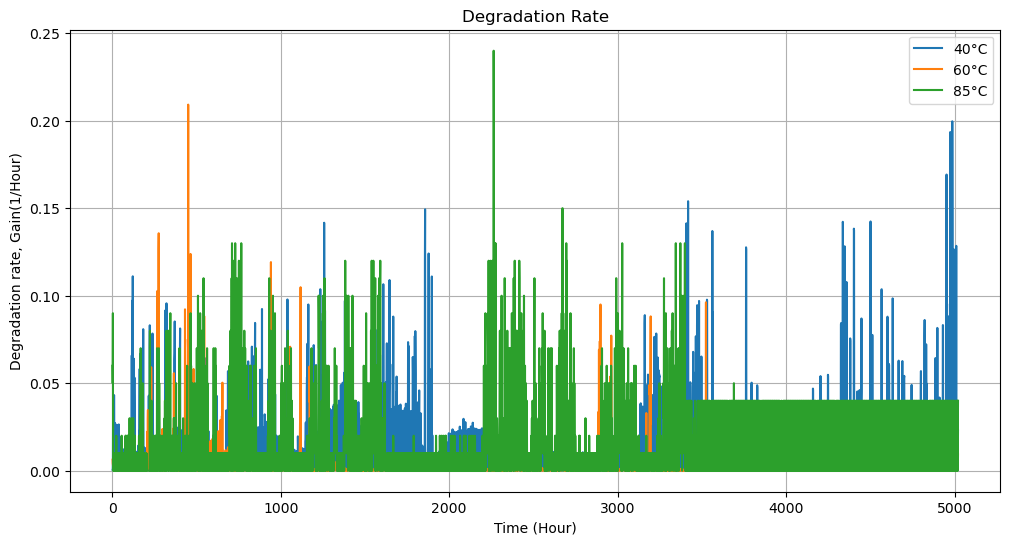

In [83]:
plt.figure(figsize=(12,6))

plt.plot(df['Scan_no'], df['DegradationRate_Gain_40C'], label="40°C")
plt.plot(df['Scan_no'], df['DegradationRate_Gain_60C'], label="60°C")
plt.plot(df['Scan_no'], df['DegradationRate_Gain_85C'], label="85°C")
plt.title("Degradation Rate")
plt.xlabel("Time (Hour)")
plt.ylabel("Degradation rate, Gain(1/Hour)")
plt.legend()
plt.grid()
plt.show()

**Show the degradation rate deviation for Gain for 125C.**

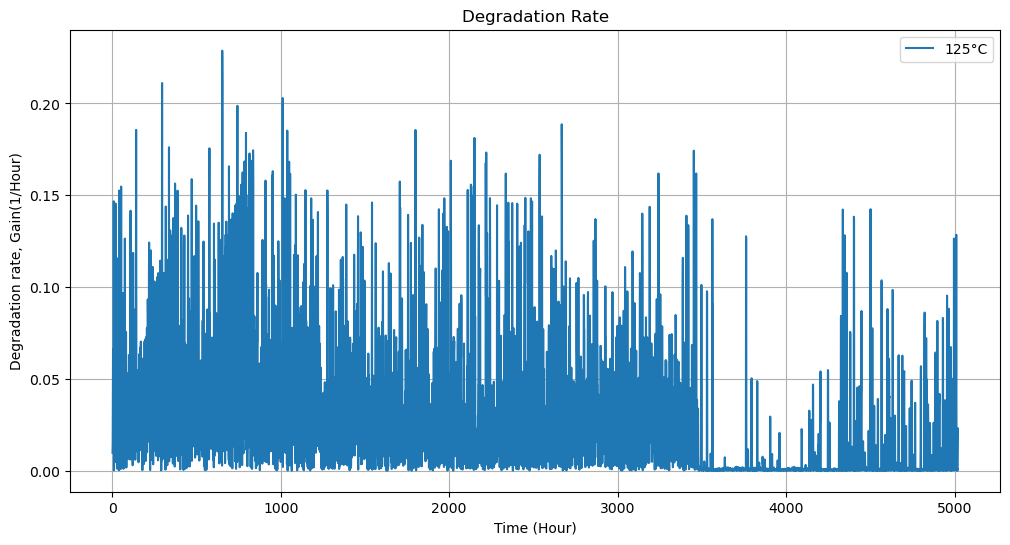

In [84]:
plt.figure(figsize=(12,6))

plt.plot(df['Scan_no'], df['DegradationRate_Gain_125C'], label="125°C")
plt.title("Degradation Rate")
plt.xlabel("Time (Hour)")
plt.ylabel("Degradation rate, Gain(1/Hour)")
plt.legend()
plt.grid()
plt.show()

**Is there any anamoly found between 125C and other temperature for Gain degradation rate?**
**Answer: The degradation rate at 125C is way more random than the degradation rate for all other temperatures.**